# **A data-driven framework for identifying productivity zones and the impact of agricultural droughts in sugarcane using SPI and unsupervised learning**

- For further description, the scientific paper, and acknowledgements for codes, dataset, and support: https://github.com/rfsilva1/productivity-zones-clustering
- Upload the dataset manually (sugarcane.csv , available on the repository)
- Upload the shapefiles manually (shapefiles can be obtained from IBGE: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=downloads (folder municipio_2020 > UFs > SP > SP_Municipios_2020.zip)
- Run this code on Google Colab CPU
- Run the different models (temporal, spatial, spatio-temporal) by changing the features that are used by the k-means model
- Baseline for comparison: classes derived from the SPI values


##0. Install Geopandas

In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 34.6 MB/s 
     |████████████████████████████████| 6.3 MB 47.1 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 


## 1. Import libraries

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import geopandas as gpd

from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch

import numpy as np

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import *

sns.set()
sns.set(rc={'figure.figsize':(16,8)})

## 2. Read CSV and remove zero values for 1995

In [ ]:
df = pd.read_csv('sugarcane.csv', sep=',')

In [ ]:
df = df[df['1995'] != 0]

##3. Verify dataset import

In [ ]:
df.head()

,city,1995,1996,1997,1998,1999,2000,spi,spi_p
0,Adamantina,75000,72000,75000,83499,90000,50000,-2.046632,-1.581169
2,Aguaí,90000,80000,80000,90000,90000,80000,-1.091615,-0.361703
4,Águas de Lindóia,60000,60000,60000,0,0,0,-1.740472,-0.153741
5,Águas de Santa Bárbara,63500,65000,60000,80000,80000,0,-1.879016,-1.005242
7,Agudos,90000,90000,70000,72000,78222,70000,-1.684505,-1.055081


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 640
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    397 non-null    object 
 1   1995    397 non-null    int64  
 2   1996    397 non-null    int64  
 3   1997    397 non-null    int64  
 4   1998    397 non-null    int64  
 5   1999    397 non-null    int64  
 6   2000    397 non-null    int64  
 7   spi     397 non-null    float64
 8   spi_p   397 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 31.0+ KB


In [ ]:
df.describe()

,1995,1996,1997,1998,1999,2000,spi,spi_p
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,73899.400504,70662.755668,72266.450882,70218.448363,69017.856423,63259.294710,-1.532535,-0.773720
std,13534.374273,21994.929355,21381.966158,23986.029410,24381.822847,30708.272549,0.577752,0.675379
min,25000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.846216,-2.635584
25%,70000.000000,65000.000000,68965.000000,65000.000000,65000.000000,60000.000000,-1.914666,-1.216208
50%,75000.000000,75000.000000,78000.000000,79111.000000,77000.000000,70000.000000,-1.503785,-0.787078
75%,80000.000000,80000.000000,80000.000000,82000.000000,80000.000000,80000.000000,-1.169824,-0.182597
max,125000.000000,120000.000000,120000.000000,101946.000000,105000.000000,150000.000000,-0.077743,1.038615


##4. Insert geolocation data

Remember to insert the shapefiles first

In [ ]:
df.rename(columns={"city": "NM_MUN"},inplace=True)

In [ ]:
sp_state = gpd.read_file('SP_Municipios_2020.shp')

In [ ]:
type(sp_state)

geopandas.geodataframe.GeoDataFrame

In [ ]:
sp_state

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.05425 -21.40465, -51.05300 -21.4..."
1,3500204,Adolfo,SP,211.055,"POLYGON ((-49.65795 -21.20333, -49.65645 -21.2..."
2,3500303,Aguaí,SP,474.554,"POLYGON ((-46.97640 -21.96818, -46.97599 -21.9..."
3,3500402,Águas da Prata,SP,142.673,"POLYGON ((-46.73501 -21.81891, -46.73431 -21.8..."
4,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.60614 -22.44173, -46.60347 -22.4..."
...,...,...,...,...,...
640,3557006,Votorantim,SP,183.517,"POLYGON ((-47.37299 -23.52200, -47.37227 -23.5..."
641,3557105,Votuporanga,SP,420.703,"POLYGON ((-50.02121 -20.33394, -50.02084 -20.3..."
642,3557154,Zacarias,SP,319.056,"POLYGON ((-49.99275 -21.03884, -49.99214 -21.0..."
643,3557204,Chavantes,SP,188.727,"POLYGON ((-49.68630 -22.93787, -49.68446 -22.9..."


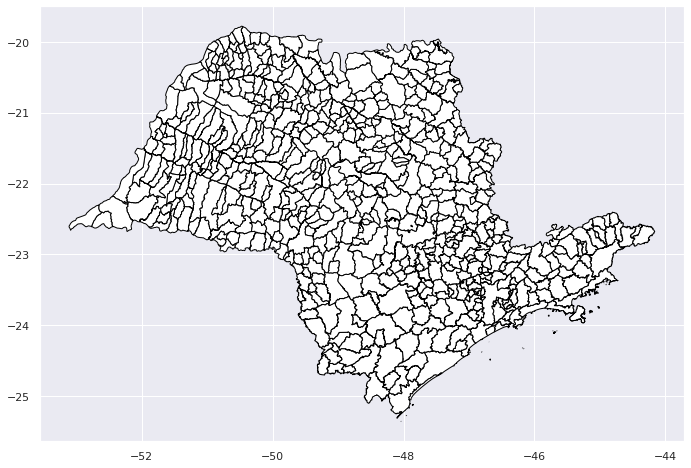

In [ ]:
sp_state.plot(color='white', edgecolor='black')

In [ ]:
df_geo = sp_state.merge(df, how='inner', on='NM_MUN')

In [ ]:
df_geo.tail()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,1995,1996,1997,1998,1999,2000,spi,spi_p
388,3556800,Viradouro,SP,217.726,"POLYGON ((-48.23257 -20.82254, -48.23312 -20.8...",90000,73404,73404,90000,80000,90000,-1.914666,-2.121502
389,3556909,Vista Alegre do Alto,SP,95.429,"POLYGON ((-48.63824 -21.13941, -48.63688 -21.1...",100000,80000,100000,100000,100000,100000,-1.331643,-0.962336
390,3557105,Votuporanga,SP,420.703,"POLYGON ((-50.02121 -20.33394, -50.02084 -20.3...",70000,70000,70000,70000,0,0,-1.276541,-1.381353
391,3557204,Chavantes,SP,188.727,"POLYGON ((-49.68630 -22.93787, -49.68446 -22.9...",80000,80000,80000,70243,61639,150000,-2.177381,-1.040963
392,3557303,Estiva Gerbi,SP,74.144,"POLYGON ((-46.93970 -22.18520, -46.93879 -22.1...",80000,0,80000,80000,80000,81111,-1.091615,-0.361703


In [ ]:
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CD_MUN    393 non-null    object  
 1   NM_MUN    393 non-null    object  
 2   SIGLA_UF  393 non-null    object  
 3   AREA_KM2  393 non-null    float64 
 4   geometry  393 non-null    geometry
 5   1995      393 non-null    int64   
 6   1996      393 non-null    int64   
 7   1997      393 non-null    int64   
 8   1998      393 non-null    int64   
 9   1999      393 non-null    int64   
 10  2000      393 non-null    int64   
 11  spi       393 non-null    float64 
 12  spi_p     393 non-null    float64 
 13  lat       393 non-null    float64 
 14  long      393 non-null    float64 
dtypes: float64(5), geometry(1), int64(6), object(3)
memory usage: 49.1+ KB


In [ ]:
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = df_geo['geometry'].centroid
x,y = [list(t) for t in zip(*map(getXY, centroidseries))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_geo['lat'] = y
df_geo['long'] = x
df_geo.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,1995,1996,1997,1998,1999,2000,spi,spi_p,lat,long
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.05425 -21.40465, -51.05300 -21.4...",75000,72000,75000,83499,90000,50000,-2.046632,-1.581169,-21.576682,-51.056802
1,3500303,Aguaí,SP,474.554,"POLYGON ((-46.97640 -21.96818, -46.97599 -21.9...",90000,80000,80000,90000,90000,80000,-1.091615,-0.361703,-22.049956,-47.040320
2,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.60614 -22.44173, -46.60347 -22.4...",60000,60000,60000,0,0,0,-1.740472,-0.153741,-22.474823,-46.603672
3,3500550,Águas de Santa Bárbara,SP,404.463,"POLYGON ((-49.19076 -22.72584, -49.19027 -22.7...",63500,65000,60000,80000,80000,0,-1.879016,-1.005242,-22.857955,-49.261037
4,3500709,Agudos,SP,966.708,"POLYGON ((-48.91186 -22.33956, -48.91210 -22.3...",90000,90000,70000,72000,78222,70000,-1.684505,-1.055081,-22.571934,-49.108768


## 5. Final dataset creation

In [ ]:
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CD_MUN    393 non-null    object  
 1   NM_MUN    393 non-null    object  
 2   SIGLA_UF  393 non-null    object  
 3   AREA_KM2  393 non-null    float64 
 4   geometry  393 non-null    geometry
 5   1995      393 non-null    int64   
 6   1996      393 non-null    int64   
 7   1997      393 non-null    int64   
 8   1998      393 non-null    int64   
 9   1999      393 non-null    int64   
 10  2000      393 non-null    int64   
 11  spi       393 non-null    float64 
 12  spi_p     393 non-null    float64 
 13  lat       393 non-null    float64 
 14  long      393 non-null    float64 
dtypes: float64(5), geometry(1), int64(6), object(3)
memory usage: 49.1+ KB


In [ ]:
df_cluster = df_geo[['1995','1996','1997','1998','1999']].copy()

In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1995    393 non-null    int64
 1   1996    393 non-null    int64
 2   1997    393 non-null    int64
 3   1998    393 non-null    int64
 4   1999    393 non-null    int64
dtypes: int64(5)
memory usage: 18.4 KB


In [ ]:
df_cluster.describe()

,1995,1996,1997,1998,1999
count,393.000000,393.000000,393.000000,393.000000,393.000000
mean,73850.030534,70567.720102,72225.905852,70150.674300,68849.157761
std,13587.882552,22077.863905,21485.861874,24084.478328,24416.514808
min,25000.000000,0.000000,0.000000,0.000000,0.000000
25%,70000.000000,65000.000000,68499.000000,65000.000000,64838.000000
50%,75000.000000,75000.000000,78500.000000,79861.000000,77000.000000
75%,80000.000000,80000.000000,80000.000000,82000.000000,80000.000000
max,125000.000000,120000.000000,120000.000000,101946.000000,104444.000000


### Data scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_data = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(scaled_data)
df_scaled.head()

,0,1,2,3,4
0,0.084740,0.064957,0.129277,0.554936,0.867356
1,1.190072,0.427773,0.362285,0.825205,0.867356
2,-1.020592,-0.479267,-0.569746,-2.916405,-2.823373
3,-0.762681,-0.252507,-0.569746,0.409470,0.457275
4,1.190072,0.881292,-0.103731,0.076883,0.384362


In [ ]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       393 non-null    float64
 1   1       393 non-null    float64
 2   2       393 non-null    float64
 3   3       393 non-null    float64
 4   4       393 non-null    float64
dtypes: float64(5)
memory usage: 15.5 KB


### Target labels creation

In [ ]:
reshaped = df_geo['2000'].values.reshape(-1,1)

#### Finding the optimal value for K

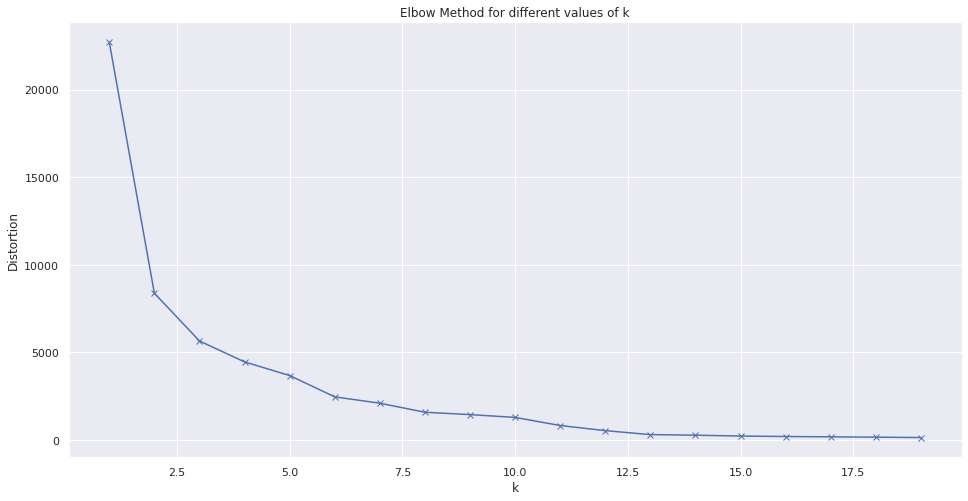

In [ ]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(reshaped)
    kmeanModel.fit(reshaped)
    distortions.append(sum(np.min(cdist(reshaped, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reshaped.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for different values of k')
plt.show()

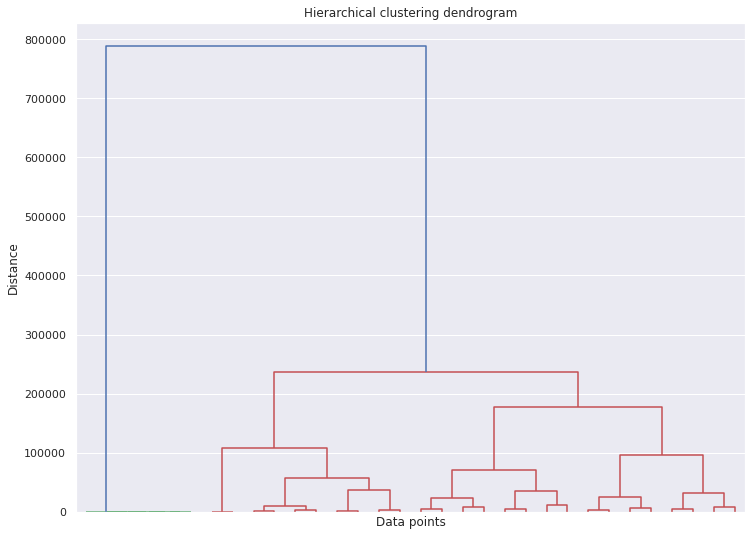

In [ ]:
hierarc_clustering_full = sch.linkage(reshaped, method = 'ward')
plt.figure(figsize = (12,9))
plt.title('Hierarchical clustering dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
sch.dendrogram(hierarc_clustering_full, truncate_mode ='level', p=5, show_leaf_counts = False, no_labels = True)
plt.show()

#### Target label generation considering 4 classes (based on the optimal k from the elbow and dendrogram analysis)

In [ ]:
target = pd.cut(df_geo['2000'], 4, labels=False, retbins=True, right=False)
target

(0      1
 1      2
 2      0
 3      0
 4      1
       ..
 388    2
 389    2
 390    0
 391    3
 392    2
 Name: 2000, Length: 393, dtype: int64,
 array([     0.,  37500.,  75000., 112500., 150150.]))

## 6. Clustering model building and implementation - K-means

### Elbow method

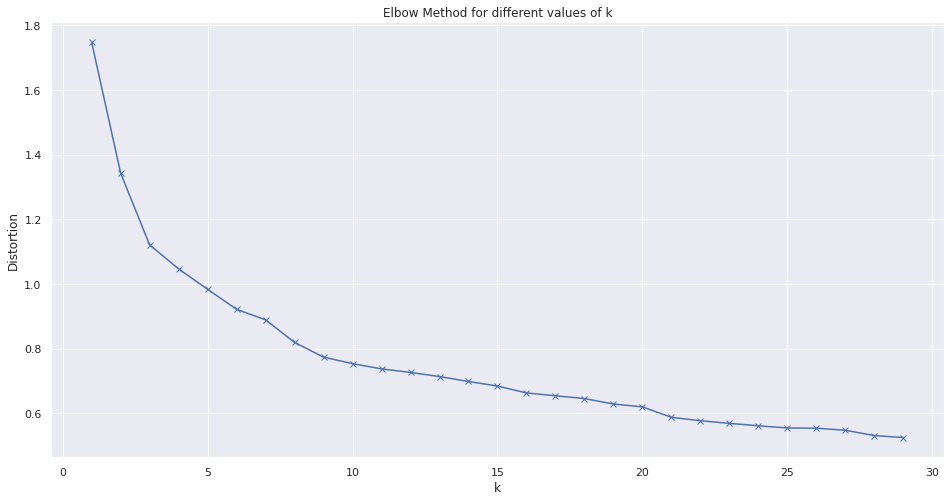

In [ ]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    kmeanModel.fit(df_scaled)
    distortions.append(sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for different values of k')
plt.show()

## Dendrogram

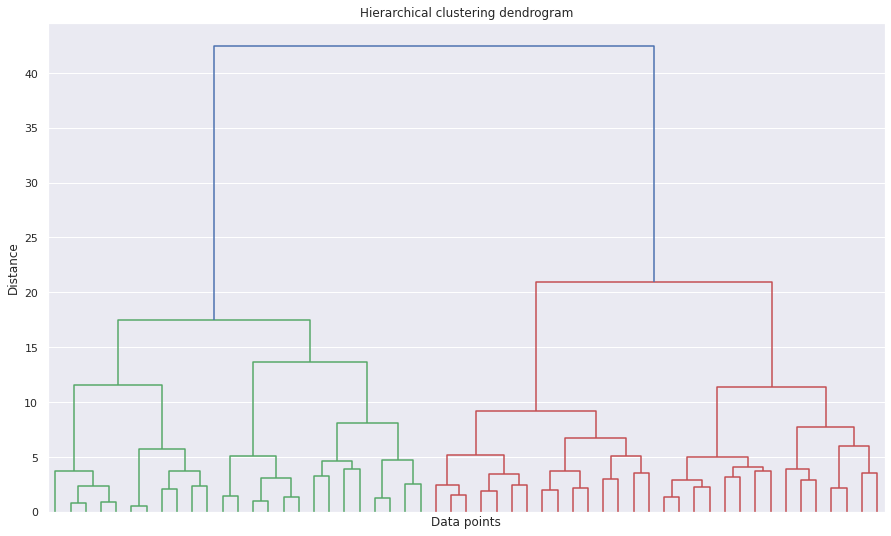

In [ ]:
hierarc_clustering_full = sch.linkage(df_scaled, method = 'ward')
plt.figure(figsize = (15,9))
plt.title('Hierarchical clustering dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
sch.dendrogram(hierarc_clustering_full, truncate_mode ='level', p=5, show_leaf_counts = False, no_labels = True)
plt.show()

### Model building with 4 clusters (based on the analysis of the dendrogram and the elbow method)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(df_scaled)

### Comparison between target and cluster labels

In [ ]:
df_comparison = df_geo[['NM_MUN','geometry','1999']]

In [ ]:
df_comparison['cluster'] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
df_comparison['target'] = target[0]

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
df_comparison.head()

,NM_MUN,geometry,1999,cluster,target
0,Adamantina,"POLYGON ((-51.05425 -21.40465, -51.05300 -21.4...",90000,1,1
1,Aguaí,"POLYGON ((-46.97640 -21.96818, -46.97599 -21.9...",90000,1,2
2,Águas de Lindóia,"POLYGON ((-46.60614 -22.44173, -46.60347 -22.4...",0,3,0
3,Águas de Santa Bárbara,"POLYGON ((-49.19076 -22.72584, -49.19027 -22.7...",80000,0,0
4,Agudos,"POLYGON ((-48.91186 -22.33956, -48.91210 -22.3...",78222,1,1


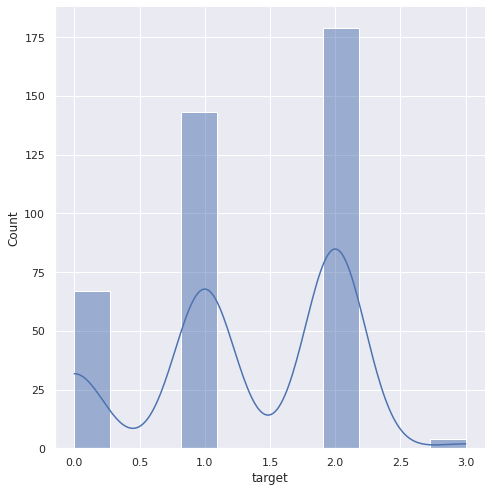

In [ ]:
sns.displot(data=df_comparison['target'], kde=True, height=7)

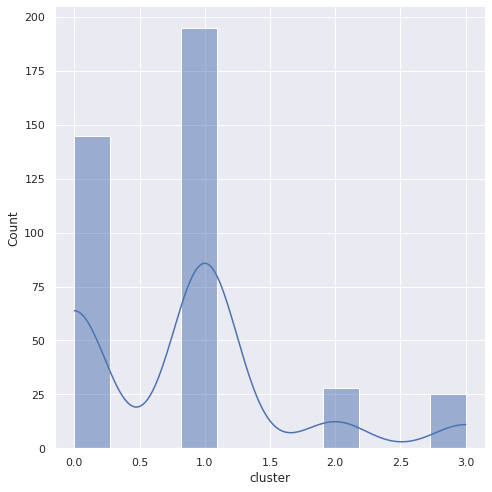

In [ ]:
sns.displot(data=df_comparison['cluster'], kde=True, height=7)

In [ ]:
df_comparison.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NM_MUN    393 non-null    object  
 1   geometry  393 non-null    geometry
 2   1999      393 non-null    int64   
 3   cluster   393 non-null    int32   
 4   target    393 non-null    int64   
dtypes: geometry(1), int32(1), int64(2), object(1)
memory usage: 16.9+ KB


In [ ]:
df_comparison[['1999','target']].groupby(by=["target"]).mean()

,1999
target,
0,33968.791045
1,70175.888112
2,80642.564246
3,77909.750000


In [ ]:
df_comparison[['1999','cluster']].groupby(by=["cluster"]).mean().sort_values(by=['1999'])

,1999
cluster,
3,0.000000
2,41213.392857
0,67378.482759
1,82737.764103


In [ ]:
df_comparison["cluster"].replace({3:0,2:1,0:2,1:3}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
df_comparison[['1999','cluster']].groupby(by=["cluster"]).mean().sort_values(by=['1999'])

,1999
cluster,
0,0.000000
1,41213.392857
2,67378.482759
3,82737.764103


##7. Model evaluation

### Map plots

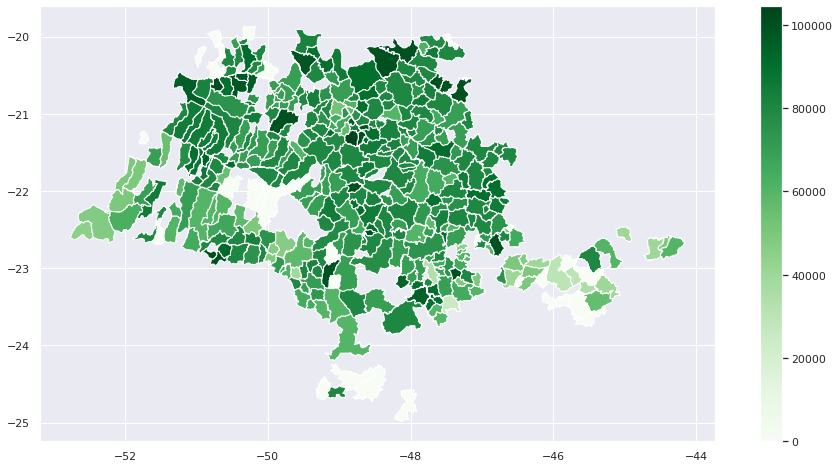

In [ ]:
df_comparison.plot(column='1999', cmap='Greens', legend=True)

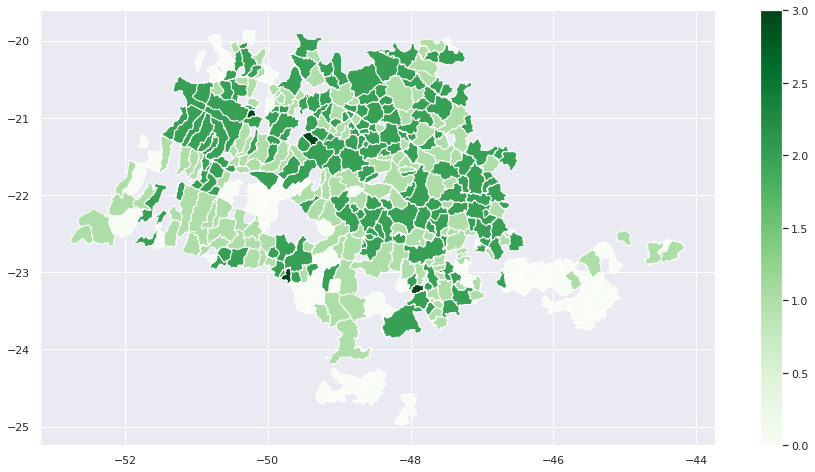

In [ ]:
df_comparison.plot(column='target', cmap='Greens', legend=True)

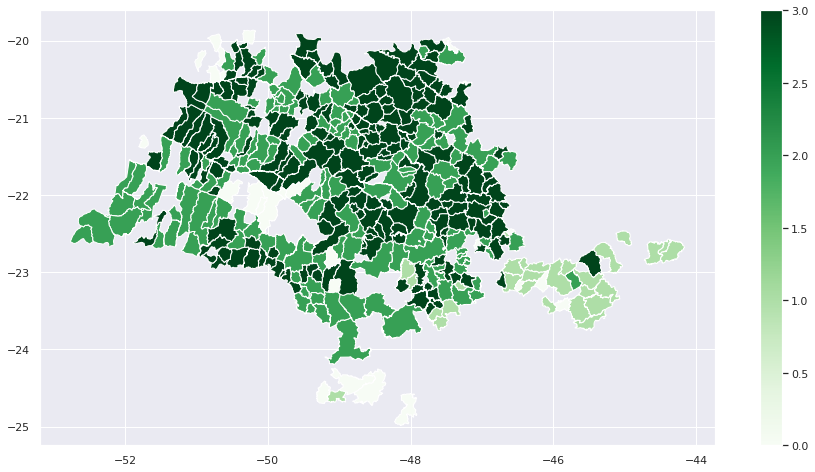

In [ ]:
df_comparison.plot(column='cluster', cmap='Greens', legend=True)

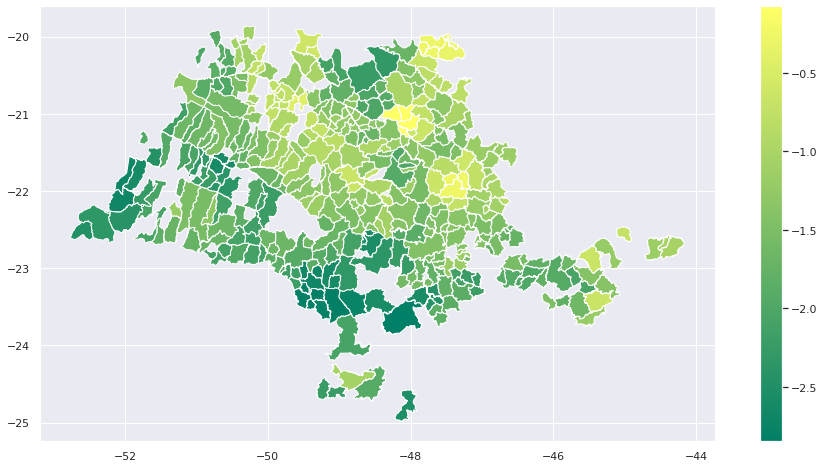

In [ ]:
df_geo.plot(column='spi', cmap='summer', legend=True)

### Creating SPI value bins for comparison

In [ ]:
bins =[-5,-1.99,-1.49,-1,0]
spi_round = pd.cut(df_geo['spi'], bins, labels=[0,1,2,3], retbins=True, right=False)
df_geo['spi_round'] = spi_round[0]
df_geo.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,1995,1996,1997,1998,1999,2000,spi,spi_p,lat,long,spi_round
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.05425 -21.40465, -51.05300 -21.4...",75000,72000,75000,83499,90000,50000,-2.046632,-1.581169,-21.576682,-51.056802,0
1,3500303,Aguaí,SP,474.554,"POLYGON ((-46.97640 -21.96818, -46.97599 -21.9...",90000,80000,80000,90000,90000,80000,-1.091615,-0.361703,-22.049956,-47.040320,2
2,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.60614 -22.44173, -46.60347 -22.4...",60000,60000,60000,0,0,0,-1.740472,-0.153741,-22.474823,-46.603672,1
3,3500550,Águas de Santa Bárbara,SP,404.463,"POLYGON ((-49.19076 -22.72584, -49.19027 -22.7...",63500,65000,60000,80000,80000,0,-1.879016,-1.005242,-22.857955,-49.261037,1
4,3500709,Agudos,SP,966.708,"POLYGON ((-48.91186 -22.33956, -48.91210 -22.3...",90000,90000,70000,72000,78222,70000,-1.684505,-1.055081,-22.571934,-49.108768,1


### Final comparison plot

Text(0.5, 1.0, 'SPI (4 categories)')

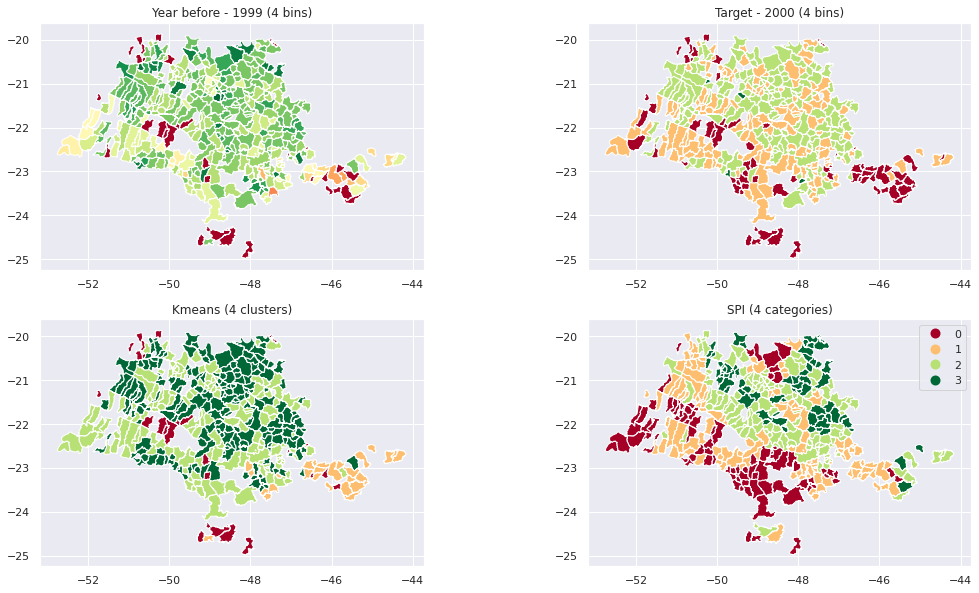

In [ ]:
f, axes = plt.subplots(figsize=(18, 10), ncols=2, nrows=2)
df_comparison.plot(ax=axes[0][0], column='1999', cmap='RdYlGn')
axes[0, 0].set_title('Year before - 1999 (4 bins)')
df_comparison.plot(ax=axes[0][1], column='target', cmap='RdYlGn')
axes[0, 1].set_title('Target - 2000 (4 bins)')
df_comparison.plot(ax=axes[1][0], column='cluster', cmap='RdYlGn')
axes[1, 0].set_title('Kmeans (4 clusters)')
df_geo.plot(ax=axes[1][1], column='spi_round', cmap='RdYlGn', legend=True)
axes[1, 1].set_title('SPI (4 categories)')

###Generating heatmaps for scenario comparison between target and cluster labels

In [ ]:
df_geo[['1999','spi_round']].groupby(by=["spi_round"]).mean().sort_values(by=['1999'])

,1999
spi_round,
1,61873.629310
0,67735.773810
2,71378.267717
3,77659.590909


In [ ]:
df_geo['spi_round'].value_counts()

2    127
1    116
0     84
3     66
Name: spi_round, dtype: int64

In [ ]:
df_comparison['target'].value_counts()

2    179
1    143
0     67
3      4
Name: target, dtype: int64

In [ ]:
df_comparison['cluster'].value_counts()

3    195
2    145
1     28
0     25
Name: cluster, dtype: int64

In [ ]:
cm = confusion_matrix(df_comparison['target'], df_comparison['cluster'])

In [ ]:
cm

array([[ 25,  18,  15,   9],
       [  0,   8,  87,  48],
       [  0,   2,  42, 135],
       [  0,   0,   1,   3]])

Text(120.5, 0.5, 'True')

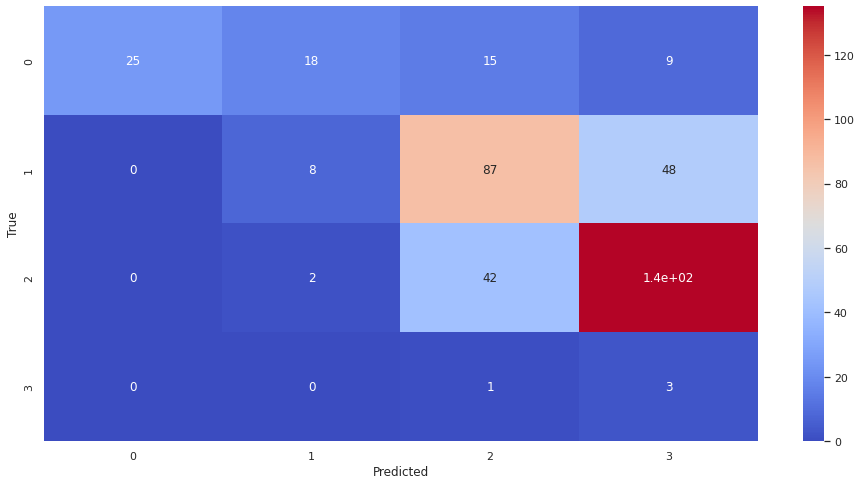

In [ ]:
sns.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

### Generating classification reports

In [ ]:
cr = classification_report(df_comparison['target'], df_comparison['cluster'],output_dict = True)

In [ ]:
cr

{'0': {'f1-score': 0.5434782608695653,
  'precision': 1.0,
  'recall': 0.373134328358209,
  'support': 67},
 '1': {'f1-score': 0.09356725146198831,
  'precision': 0.2857142857142857,
  'recall': 0.055944055944055944,
  'support': 143},
 '2': {'f1-score': 0.2592592592592593,
  'precision': 0.2896551724137931,
  'recall': 0.2346368715083799,
  'support': 179},
 '3': {'f1-score': 0.030150753768844223,
  'precision': 0.015384615384615385,
  'recall': 0.75,
  'support': 4},
 'accuracy': 0.1984732824427481,
 'macro avg': {'f1-score': 0.23161388133991428,
  'precision': 0.39768851837817354,
  'recall': 0.35342881395266124,
  'support': 393},
 'weighted avg': {'f1-score': 0.24509203781121627,
  'precision': 0.4065316976609422,
  'recall': 0.1984732824427481,
  'support': 393}}

In [ ]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=df_comparison['target'],y_pred=df_comparison['cluster'])) 
print("Classification report\n",metrics.classification_report(y_true=df_comparison['target'],y_pred=df_comparison['cluster'])) 

Confusion matrix
 [[ 25  18  15   9]
 [  0   8  87  48]
 [  0   2  42 135]
 [  0   0   1   3]]
Classification report
               precision    recall  f1-score   support

           0       1.00      0.37      0.54        67
           1       0.29      0.06      0.09       143
           2       0.29      0.23      0.26       179
           3       0.02      0.75      0.03         4

    accuracy                           0.20       393
   macro avg       0.40      0.35      0.23       393
weighted avg       0.41      0.20      0.25       393



In [ ]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"Cluster 0"+'\033[0m')
print("Precision = {0:0.3f}".format(cr["0"]["precision"]))
print("Recall = {0:0.3f}".format(cr["0"]["recall"]))
print("F1-score = {0:0.3f}".format(cr["0"]["f1-score"]))
print("Support = {0:0.3f}".format(cr["0"]["support"]))
print('\033[1m'+"Cluster 1"+'\033[0m')
print("Precision = {0:0.3f}".format(cr["1"]["precision"]))
print("Recall = {0:0.3f}".format(cr["1"]["recall"]))
print("F1-score = {0:0.3f}".format(cr["1"]["f1-score"]))
print("Support = {0:0.3f}".format(cr["1"]["support"]))
print('\033[1m'+"Cluster 2"+'\033[0m')
print("Precision = {0:0.3f}".format(cr["2"]["precision"]))
print("Recall = {0:0.3f}".format(cr["2"]["recall"]))
print("F1-score = {0:0.3f}".format(cr["2"]["f1-score"]))
print("Support = {0:0.3f}".format(cr["2"]["support"]))
print('\033[1m'+"Cluster 3"+'\033[0m')
print("Precision = {0:0.3f}".format(cr["3"]["precision"]))
print("Recall = {0:0.3f}".format(cr["3"]["recall"]))
print("F1-score = {0:0.3f}".format(cr["3"]["f1-score"]))
print("Support = {0:0.3f}".format(cr["3"]["support"]))

Kmeans++:
Cluster 0
Precision = 1.000
Recall = 0.373
F1-score = 0.543
Support = 67.000
Cluster 1
Precision = 0.286
Recall = 0.056
F1-score = 0.094
Support = 143.000
Cluster 2
Precision = 0.290
Recall = 0.235
F1-score = 0.259
Support = 179.000
Cluster 3
Precision = 0.015
Recall = 0.750
F1-score = 0.030
Support = 4.000


### Calculating clustering metrics

In [ ]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(df_comparison['target'], df_comparison['cluster']))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(df_comparison['target'], df_comparison['cluster']))
print('Homogeneity score: ', metrics.homogeneity_score(df_comparison['target'], df_comparison['cluster']))
print('Completeness score: ', metrics.completeness_score(df_comparison['target'], df_comparison['cluster']))
print('V-measure: ', metrics.v_measure_score(df_comparison['target'], df_comparison['cluster']))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(df_comparison['target'], df_comparison['cluster']))

Clustering metrics - supervised
Adjusted Rand score:  0.24081153229052507
Mutual info score:  0.24312893917836664
Homogeneity score:  0.2518640463465786
Completeness score:  0.25076322222294256
V-measure:  0.2513124288052463
Fowlkes-Mallows score:  0.5282611496012486


In [ ]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(scaled_data, df_comparison['cluster'], metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(scaled_data, df_comparison['cluster']))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(scaled_data, df_comparison['cluster']))

Clustering metrics - unsupervised
Silhouette:  0.3451309774052647
Davies-Bouldin Index:  1.1797327390850267
Calinski-Harabasz Index:  264.6394778625887


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


###Comparison of target with SPI values

In [ ]:
cm2 = confusion_matrix(df_comparison['target'], df_geo['spi_round'])

In [ ]:
cm2

array([[23, 29, 11,  4],
       [31, 42, 47, 23],
       [29, 44, 68, 38],
       [ 1,  1,  1,  1]])

Text(120.5, 0.5, 'True')

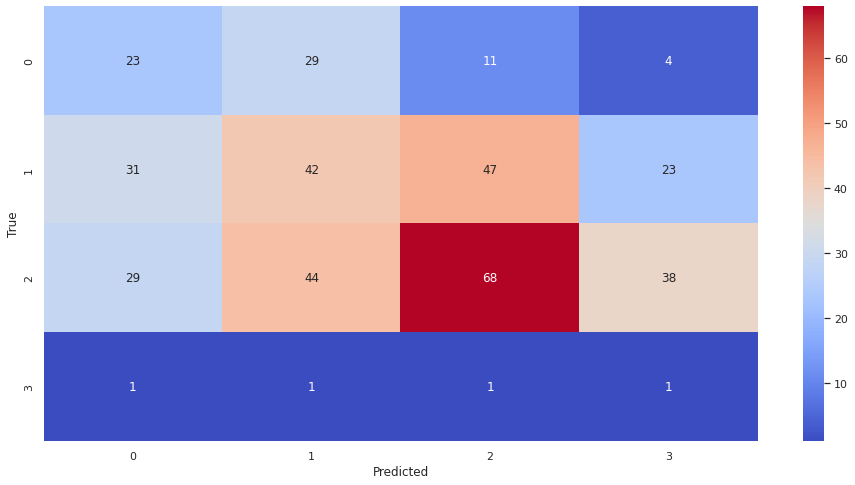

In [ ]:
sns.heatmap(cm2,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
cr2 = classification_report(df_comparison['target'], df_geo['spi_round'],output_dict = True)

In [ ]:
cr2

{'0': {'f1-score': 0.304635761589404,
  'precision': 0.27380952380952384,
  'recall': 0.34328358208955223,
  'support': 67},
 '1': {'f1-score': 0.32432432432432434,
  'precision': 0.3620689655172414,
  'recall': 0.2937062937062937,
  'support': 143},
 '2': {'f1-score': 0.4444444444444445,
  'precision': 0.5354330708661418,
  'recall': 0.37988826815642457,
  'support': 179},
 '3': {'f1-score': 0.028571428571428574,
  'precision': 0.015151515151515152,
  'recall': 0.25,
  'support': 4},
 'accuracy': 0.34096692111959287,
 'macro avg': {'f1-score': 0.2754939897324003,
  'precision': 0.2966157688361055,
  'recall': 0.3167195359880676,
  'support': 393},
 'weighted avg': {'f1-score': 0.37266874217483387,
  'precision': 0.42245350104287294,
  'recall': 0.34096692111959287,
  'support': 393}}

In [ ]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=df_comparison['target'],y_pred=df_geo['spi_round'])) 
print("Classification report\n",metrics.classification_report(y_true=df_comparison['target'],y_pred=df_geo['spi_round'])) 

Confusion matrix
 [[23 29 11  4]
 [31 42 47 23]
 [29 44 68 38]
 [ 1  1  1  1]]
Classification report
               precision    recall  f1-score   support

           0       0.27      0.34      0.30        67
           1       0.36      0.29      0.32       143
           2       0.54      0.38      0.44       179
           3       0.02      0.25      0.03         4

    accuracy                           0.34       393
   macro avg       0.30      0.32      0.28       393
weighted avg       0.42      0.34      0.37       393



In [ ]:
print('\033[1m'+"SPI values:"+'\033[0m')
print('\033[1m'+"Cluster 0"+'\033[0m')
print("Precision = {0:0.3f}".format(cr2["0"]["precision"]))
print("Recall = {0:0.3f}".format(cr2["0"]["recall"]))
print("F1-score = {0:0.3f}".format(cr2["0"]["f1-score"]))
print("Support = {0:0.3f}".format(cr2["0"]["support"]))
print('\033[1m'+"Cluster 1"+'\033[0m')
print("Precision = {0:0.3f}".format(cr2["1"]["precision"]))
print("Recall = {0:0.3f}".format(cr2["1"]["recall"]))
print("F1-score = {0:0.3f}".format(cr2["1"]["f1-score"]))
print("Support = {0:0.3f}".format(cr2["1"]["support"]))
print('\033[1m'+"Cluster 2"+'\033[0m')
print("Precision = {0:0.3f}".format(cr2["2"]["precision"]))
print("Recall = {0:0.3f}".format(cr2["2"]["recall"]))
print("F1-score = {0:0.3f}".format(cr2["2"]["f1-score"]))
print("Support = {0:0.3f}".format(cr2["2"]["support"]))
print('\033[1m'+"Cluster 3"+'\033[0m')
print("Precision = {0:0.3f}".format(cr2["3"]["precision"]))
print("Recall = {0:0.3f}".format(cr2["3"]["recall"]))
print("F1-score = {0:0.3f}".format(cr2["3"]["f1-score"]))
print("Support = {0:0.3f}".format(cr2["3"]["support"]))

SPI values:
Cluster 0
Precision = 0.274
Recall = 0.343
F1-score = 0.305
Support = 67.000
Cluster 1
Precision = 0.362
Recall = 0.294
F1-score = 0.324
Support = 143.000
Cluster 2
Precision = 0.535
Recall = 0.380
F1-score = 0.444
Support = 179.000
Cluster 3
Precision = 0.015
Recall = 0.250
F1-score = 0.029
Support = 4.000
